# CSCI 5897 Homework 4
### Anya Lee

### **Problem 1**
The goal of this problem is to try out some of the methods we developed in class to estimate $R_0$ or $R_t$ from data. You'll also have a chance to refresh yourself on confidence intervals. 

**What we know about Bison/Ralphie Unexplained Hiccups disease:**

* BRUH disease affects bison like Ralphie.
* It is non-fatal, and does not affect mortality.
* Diagnosed via sporadic symptoms — mostly hiccups and bad breath.
* There are 100,000 bison in the herd
* Typical Bison lifespan in this herd is 100 weeks.
* Typical infection lasts 2 weeks, and a separate study found duration of infection exponentially distributed.

**Weekly Incidence Data**
* Weekly new case counts were recorded for ~10 years, which you can find on Canvas as **all\_weeks.csv**.
* Ecologists believe they are identifying only 10\% of cases due to lack of funds.
* This 10\% ascertainment is an approximation — varies from week to week.

**Prevalence and Seroprevalence Studies**
* Ted Turner paid for a prevalence study to be done. A team of researchers went out into the field at night dressed in bison disguises, and subjected 1000 bison to tickling — a decent way to see if they have hiccups. Only 7 had hiccups. 
* The estate of Buffalo Bill paid for a seroprevalence study to be done. They took blood samples from 1000 randomly chosen bison and found that 517 had  BRUH antibodies.

a. Estimate $R_0$ by examining the period of exponential growth (Method 1, Week 9). Be sure to show your work and plots as relevant. In the process, look up the 95\% confidence interval associated with estimating a slope from data points, and use the slope's confidence interval to provide a confidence interval for your $R_0$ estimate.

Method 1 from Week 9 involves estimating $R_0$ using epidemic growth data:
$$
R_0 \approx 1 + \frac{\hat{m}}{\gamma + \mu}
$$
where $\hat{m}$ is the slope estimate from data where $m=(R_0 - 1)(\gamma + \mu)$, $\gamma$ is the recovery rate, and $\mu$ is the death rate. This means that $\frac{1}{\gamma}$ is the typical duration of infection and $\frac{1}{\mu}$ is the typical life expectancy. 

For our case, we know typical duration infection lasts 2 weeks so we can find $\gamma$:
\begin{align*}
\frac{1}{\gamma} &= 2 \\
\gamma & = \frac{1}{2} \\
\gamma &= 0.5
\end{align*}
Similarly, we know typical Bison lifespan is 100 weeks so we can solve for $\mu$:
\begin{align*}
\frac{1}{\mu} &= 100\\
\mu & = \frac{1}{100} \\
\mu &= 0.01
\end{align*}

In [1]:
# Load all_weeks.csv data
import pandas as pd
import numpy as np

all_weeks_df = pd.read_csv('hw4_data/HW4_all_weeks.csv')
print(len(all_weeks_df)) # 501 rows
all_weeks_df.head()

501


,Week,New Cases
0,1,4
1,2,2
2,3,2
3,4,4
4,5,9


To answer this problem, we first need to see where exponential growth occurs. Let's plot the number of new cases for each week. 

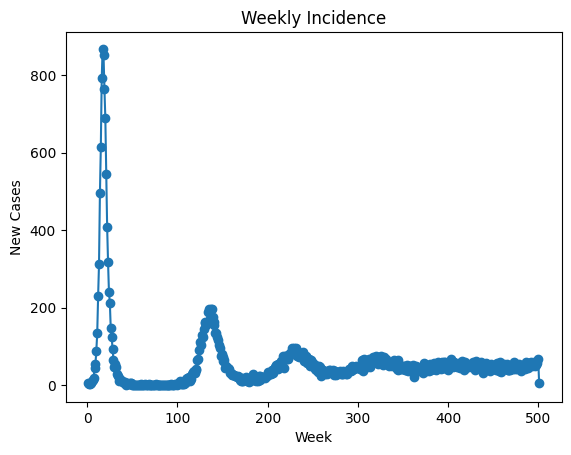

In [2]:
import matplotlib.pyplot as plt

plt.plot(all_weeks_df['Week'], all_weeks_df['New Cases'], marker='o')
plt.xlabel('Week')
plt.ylabel('New Cases')
plt.title('Weekly Incidence')
plt.show()

In [3]:
import statsmodels.api as sm  # OLS
from scipy.stats import t  # t-distribution for CI

# Use oridinary least squares (OLS) to get slope estimate
best = {'r2': -np.inf}
# Period of exponential growth occurs definitely between 0 and 50 weeks
min_len = 10
max_len = 50
# Loop over all possible start weeks and lengths to find best fit (highest R^2) for log-linear model
for length in range(min_len, max_len+1):
    for start in range(0, len(all_weeks_df)-length+1):
        w = slice(start, start+length)
        y = all_weeks_df['New Cases'].iloc[w]
        if (y <= 0).any(): 
            continue
        X = sm.add_constant(all_weeks_df['Week'].iloc[w])
        model = sm.OLS(np.log(y), X).fit()
        slope = model.params['Week']
        r2 = model.rsquared
        if slope > 0 and r2 > best['r2']:
            best = {'start':start, 'len':length, 'r2':r2, 'model':model, 'w':w}

best['start'], best['len'], best['r2']
model = best['model']
# get OLS model output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              New Cases   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     886.3
Date:                Wed, 05 Nov 2025   Prob (F-statistic):           1.76e-09
Time:                        16:48:48   Log-Likelihood:                 6.6697
No. Observations:                  10   AIC:                            -9.339
Df Residuals:                       8   BIC:                            -8.734
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1112      0.152     -0.733      0.4

In [4]:
### GET SLOPE AND R0 ESTIMATES WITH 95% CI ###
# get slope and CI
m_hat = model.params['Week']
se_m = model.bse['Week']
n = best['len']
# use t-distribution for CI - two-sided 95% CI; 1-alpha/2=0.975
tval = t.ppf(0.975, n-2)
# CI for m = m-hat +/- t-value * standard error
m_lower = m_hat - tval*se_m 
m_upper = m_hat + tval*se_m

# Define gamma and mu
gamma = 1/2
mu = 1/100
den = gamma + mu # denominator for R0 calculation = 0.51

# Apply R0 approximation = 1 + m-hat / (gamma + mu)
R0_hat = 1 + m_hat/den
R0_lower = 1 + m_lower/den
R0_upper = 1 + m_upper/den

print("m-hat =", m_hat, "95% CI for m-hat= [", m_lower, ",", m_upper, "]")  # manually calculated CI matches CI from model summary output
print("R0-est =", R0_hat, "95% CI for R0-est = [", R0_lower, ",", R0_upper, "]") 

m-hat = 0.45512377946917004 95% CI for m-hat= [ 0.41987121523436494 , 0.49037634370397515 ]
R0-est = 1.8923995675866079 95% CI for R0-est = [ 1.8232768926164018 , 1.961522242556814 ]


/Users/anya/.virtualenvs/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


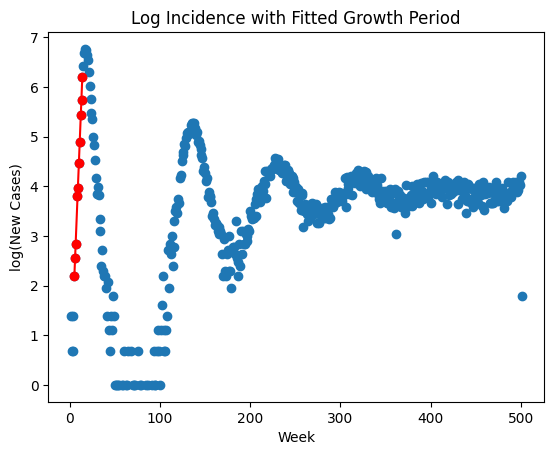

In [5]:
# Plot log incidence and fit window
plt.scatter(all_weeks_df['Week'], np.log(all_weeks_df['New Cases']), label='log(New Cases)')
w = range(best['start'], best['start']+best['len'])
plt.scatter(all_weeks_df['Week'].iloc[w], np.log(all_weeks_df['New Cases'].iloc[w]), color='red')
X_full = sm.add_constant(all_weeks_df['Week'].iloc[w])
y_pred = model.predict(X_full)
plt.plot(all_weeks_df['Week'].iloc[w], y_pred, color='red')
plt.xlabel('Week'); plt.ylabel('log(New Cases)'); plt.title('Log Incidence with Fitted Growth Period')
plt.show()

After performing ordinary least squares (OLS) on the data, we find that the slope estimate $\hat{m}=0.4551$ and the 95\% confidence interval for $\hat{m}$ is $[\hat{m}_{lower}, \hat{m}_{upper}] = [0.420, 0.490]$ from the output. Using this we can estimate $R_0$ and obtain a 95\% confidence interval for $R_0$:

\begin{align*}
R_0 &\approx 1 + \frac{\hat{m}}{\gamma + \mu} \\
R_0 &\approx 1 + \frac{0.4551}{0.5 + 0.01} \\
R_0 &\approx 1 + 0.8923529411764706 \\
R_0 &\approx 1.8924
\end{align*}

To find the lower and upper bounds for the 95\% confidence interval for $R_0$, we use the lower and upper estimates of $\hat{m}$ as follows:
\begin{align*}
R_{0, lower} &\approx 1 + \frac{\hat{m}_{lower}}{\gamma + \mu} \\
R_{0, lower} &\approx 1 + \frac{0.420}{0.5 + 0.01} \\
R_{0, lower} &\approx 1 + 0.8235294117647058 \\
R_{0, lower} &\approx 1.8235
\end{align*}

\begin{align*}
R_{0, upper} &\approx 1 + \frac{\hat{m}_{upper}}{\gamma + \mu} \\
R_{0, upper} &\approx 1 + \frac{0.490}{0.5 + 0.01} \\
R_{0, upper} &\approx 1 + 0.9607843137254901 \\
R_{0, upper} &\approx 1.9608
\end{align*}

Thus we obtain the 95\% CI for the $R_0$ estimate: $[R_{0, lower}, R_{0, upper}] = [1.8235, 1.9608]$.

b. Estimate $R_0$ by utilizing the prevalence *or* seroprevalence data. (Method 2 or 4, Week 9). Be sure to show your work and plots as relevant. Write down (or look up) the 95\% confidence interval for the prevalence/seroprevalence estimate, and use it to provide a confidence interval for $R_0$.

The estimate for $R_0$ from equilibrium prevalence is
$$
R_0 = \frac{1}{1-i_{\text{eq}}(\frac{\gamma}{\mu}+1)}
$$

The estimate for $R_0$ from seroprevalence is 
$$
R_0 = \frac{1}{1-\text{seroprevalence}}
$$

From the prevalence and seroprevalence studies in the problem statement, we know the following:
* Sample size for prevalence ($n_p$) is 1000
* Positive cases from prevalence study ($x_p$) is 7
* Sample size for seroprevalence ($n_s$) is 1000
* Positive blood samples from seroprevalence study ($x_s$) is 517.
* From part (a), we know the recovery rate and death rate: $\gamma = 0.5$ and $\mu=0.01$ 
Given these, the sample proportion for the prevalence study is $\frac{7}{1000}$ and the sample proportion for the seroprevalence study is $\frac{517}{1000}$.

The 95\% confidence interval for proportions is $$\hat{p} \pm z_{\alpha/2}\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$$ where $\hat{p} = \frac{x}{n}$ is the sample proportion, $x$ is the number of successes, $n$ is the sample size, and $z_{\alpha/2} = 1.96$ for a 95\% confidence interval since $z_{0.05/2}=z_{0.025}=1.96$ assuming normal approximation.

For this part, we will estimate $R_0$ utilizing prevalence. Let's first find the 95\% confidence interval for the proportion $i_{eq}$. We know $i_{eq}$ is the equilibrium prevalence which is the fraction currently infected. Thus 
    $$i_{eq} = \frac{7}{1000} = 0.007$$

The 95\% confidence interval follows the format:
\begin{align*}
    i_{eq} &\pm 1.96\sqrt{\frac{i_{eq}(1-i_{eq})}{n_p}}\\
    0.007 &\pm 1.96\sqrt{\frac{0.007(1-0.007)}{1000}}\\
    0.007 &\pm 1.96\sqrt{\frac{0.007(0.993)}{1000}}
\end{align*}

Calculating this we get the interval for $i_{eq}$ is $[i_{eq, lower}, i_{eq, upper}]$: $$\big[0.007 - 1.96(0.00263), 0.007+1.96(0.00263)\big]$$
$$\big[0.0018, 0.0122\big]$$

Now let's use these interval estimates of $i_{eq}$ to calculate a 95\% confidence interval for the $R_0$ estimate:

\begin{align*}
    R_{0, lower} &\approx \frac{1}{1-i_{eq, lower}\left(\frac{\gamma}{\mu}+1\right)} \\
    R_{0, lower} &\approx \frac{1}{1-0.0018\left(\frac{0.5}{0.01}+1\right)} \\
    R_{0, lower} &\approx \frac{1}{1-0.0018\left(50 + 1\right)} \\
    R_{0, lower} &\approx \frac{1}{1-0.0018\left(51\right)} \\
    R_{0, lower} &\approx \frac{1}{0.9082} \\
    R_{0, lower} &\approx 1.1011
\end{align*}

\begin{align*}
R_{0, upper} &\approx \frac{1}{1-i_{eq, upper}\left(\frac{\gamma}{\mu}+1\right)} \\
R_{0, upper} &\approx \frac{1}{1-0.0122\left(\frac{0.5}{0.01}+1\right)} \\
R_{0, upper} &\approx \frac{1}{1-0.0122\left(50+1\right)} \\
R_{0, upper} &\approx \frac{1}{1-0.0122\left(51\right)} \\
R_{0, upper} &\approx \frac{1}{0.3778} \\
R_{0, upper} &\approx 2.6469
\end{align*}
The 95\% confidence found for $R_0$ estimate is: $\left[1.1011, 2.6469\right]$.

We can estimate $R_0$ now.
\begin{align*}
    R_0 &\approx \frac{1}{1-i_{\text{eq}}\left(\frac{\gamma}{\mu}+1\right)} \\
    R_0 &\approx \frac{1}{1-0.007\left(\frac{0.5}{0.01}+1\right)} \\
    R_0 &\approx \frac{1}{1-0.007\left(51\right)} \\
    R_0 &\approx \frac{1}{0.643} \\
    R_0 &\approx 1.5552
\end{align*}

c. (Grad / EC) Estimate $R_0$ a third way from the same data. 

For this part, I'll estimate $R_0$ with seroprevalence. We will use previous information in other parts:
* Sample size for seroprevalence ($n_s$) is 1000
* Positive blood samples from seroprevalence study ($x_s$) is 517.
* From part (a), we know the recovery rate and death rate: $\gamma = 0.5$ and $\mu=0.01$ 

Seroprevalence is equivalent to the proportion of those with BRUH antibodies is $s=\frac{517}{1000} = 0.517$. We can now estimate $R_0$: 

\begin{align*}
    R_0 &\approx \frac{1}{1-\text{seroprevalence}}\\
    R_0 &\approx \frac{1}{1-\text{0.517}} \\
    R_0 &\approx \frac{1}{0.483}\\
    R_0 &\approx 2.0704
\end{align*}

Following the same logic for the 95\% confidence interval for proportions as part (b), we can find the 95\% confidence interval for this $R_0$ estimate with the 95\% confidence interval for seroprevalence:

\begin{align*}
    s &\pm 1.96\sqrt{\frac{s(1-s)}{n_s}}\\
    0.517 &\pm 1.96\sqrt{\frac{0.517(1-0.517)}{1000}}\\
    0.517 &\pm 1.96\sqrt{\frac{0.517(0.483)}{1000}}
\end{align*}
Calculating this we get the interval for $s$ is $[s_{lower}, s_{upper}]$: $$\big[0.517 - 1.96(0.0158), 0.517+1.96(0.0158)\big]$$
    $$\big[0.4860, 0.548\big]$$
Let's use this result to obtain a 95\% confidence interval for $R_0$ estimated with seroprevalence.

\begin{align*}
R_{0, lower} &\approx \frac{1}{1-s_{lower}} \\
R_{0, lower} &\approx \frac{1}{1-0.4860} \\
R_{0, lower} &\approx \frac{1}{0.514} \\
R_{0, lower} &\approx 1.9455\\
\end{align*}

\begin{align*}
R_{0, upper} &\approx \frac{1}{1-s_{upper}} \\
R_{0, upper} &\approx \frac{1}{1-0.548} \\
R_{0, upper} &\approx \frac{1}{0.4519} \\
R_{0, upper} &\approx 2.2129\\
\end{align*}
The 95\% confidence found for $R_0$ estimate is: $\left[1.9455, 2.2129\right]$.

d. Compare your estimates, the uncertainty associated with each, and discuss what might cause them to be different.

The estimates we have obtained are:
* Method 1: $R_0$ from exponential growth 
    * $R_0 \approx 1.8924$ ; 95\% confidence interval: $[1.8235, 1.9608]$

* Method 2: $R_0$ from prevalence
    * $R_0 \approx 1.5552$; 95\% confidence interval $\left[1.1011, 2.6469\right]$

* Method 4: $R_0$ from seroprevalence
    * $R_0 \approx  2.0704$; 95\% confidence interval:$\left[1.9455, 2.2129\right]$

Immediately, we can see that the exponential growth and seroprevalence estimates for $R_0$ are very close. Additionally, their 95\% confidence intervals overlap indicating they are consistent with each other at this confidence level. The prevalence estimate is lower and has the widest confidence interval which means the estimate has greater uncertainty and is less precise. 

These estimates are likely different simply because they take into consideration different metrics to measure populations and these metrics are influenced by the data and time frames. Note that using exponential growth only covers a short and early time window of new cases, whereas seroprevalence reflects cumulative number of infections over time. In contrast, a prevalence study is a very small, instantaneous measure of infections. 

e. (EC for all) Estimate $R_t$ using Method 5.

Method 5 is estimating $R_t$ using the generation interval distribution using a method from Wallinga and Teunis.

Let the generation interval for the infectious disease have distribution $\omega(\tau)$. Then the relative likelihood that case $i$ was caused by case $j$ is 

$$
p_{ij} = \frac{\omega(t_i-t_j)}{\sum_{k, k\neq i}\omega(t_i-t_k)}
$$

where $t_i$, $t_j$, and $t_k$ are the times of symptom onset from cases $i$, $j$, and $k$, respectively. 

Then the effective reproduction number for case $j$ is the sum over all cases $i$, weighted by the relative likelihood that it was case $j$ that caused $i$,

$$
R_j = \sum_i p_{ij}
$$

Note that we want to aggregate by week to get $R_t$ since $R_t$ is the mean of $R_j$ for all cases with onset in week $t$. We know that the typical duration of infection is 2 weeks and exponentially distributed, so we can use this for our generation interval. 

In [13]:
from collections import defaultdict

# Load data again
df = pd.read_csv("hw4_data/HW4_all_weeks.csv") 
df.columns = ['Week', 'Cases']
df = df.sort_values('Week').reset_index(drop=True)

# Parameters
mean_gi = 2.0   # mean generation interval (weeks)
K = 20 # maximum lag to consider, consider infx links up to 20 weeks apart

# Expand weekly counts into individual cases
## we want to represent each infected bison as an individual case with its week on onset
case_times = []
for _, row in df.iterrows():
    case_times.extend([int(row['Week'])] * int(row['Cases']))
case_times = np.array(case_times) # array of case onset weeks
N = len(case_times) # total # of individual cases across all weeks

In [14]:
# Define generation interval \omega(tau): discrete prob dist of generation interval
taus = np.arange(1, K+1) # lags 
rate = 1.0 / mean_gi  # mean of exponential distribution is 1/gamma
omega = np.exp(-rate*(taus-0.5)) - np.exp(-rate*(taus+0.5))  # discretized exponential GI
omega = omega / omega.sum()  # normalize so all probs sum to 1
omega_dict = {k+1: float(omega[k]) for k in range(len(omega))}

## note we approx the prob that the generation interval falls between tau-0.5 and tau+0.5
# omega_dict stores lag:prob weight, where prob weight is likelihood of case i was infected by case j at lag tau

In [15]:
# Compute individual per-case reproduction numbers R_j
week_to_indices = defaultdict(list)
for idx, t in enumerate(case_times):
    week_to_indices[t].append(idx) # dict that maps week t to list of case indices

R_j = np.zeros(N, dtype=float) # empty array to store each individual case’s estimated reproduction number

# Apply Wallinga-Teunis method
for i in range(N):
    t_i = case_times[i]
    prev_indices = []
    weights = []
    for lag in range(1, K+1):
        t_j = t_i - lag
        if t_j <= 0:
            continue
        inds = week_to_indices.get(t_j, [])
        if len(inds) > 0:
            prev_indices.extend(inds)
            weights.extend([omega_dict[lag]] * len(inds))
    if len(prev_indices) == 0:
        continue
    weights = np.array(weights, dtype=float)
    denom = weights.sum()
    if denom <= 0:
        continue
    p = weights / denom  # p_ij probabilities
    for jidx, prob in zip(prev_indices, p):
        R_j[jidx] += prob

In [ ]:
# Aggregate R_j to get R_t by week
weeks = sorted(df['Week'].unique())
R_t = []
for w in weeks:
    inds = week_to_indices.get(w, [])
    R_t.append(np.mean(R_j[inds]) if len(inds) > 0 else np.nan) # weeks with no cases get NaN

# Store R_t in DataFrame
rt_df = pd.DataFrame({
    'Week': weeks,
    'Cases': df['Cases'],
    'R_t': R_t
})

# avereage of rolling window to smooth noise from week to week
rt_df['R_t_smooth'] = rt_df['R_t'].rolling(window=3, center=True, min_periods=1).mean()

print(rt_df.head())

   Week  Cases       R_t  R_t_smooth
0     1      4  1.726060    1.873754
1     2      2  2.021449    2.111778
2     3      2  2.587827    2.489370
3     4      4  2.858834    2.663718
4     5      9  2.544492    2.656173


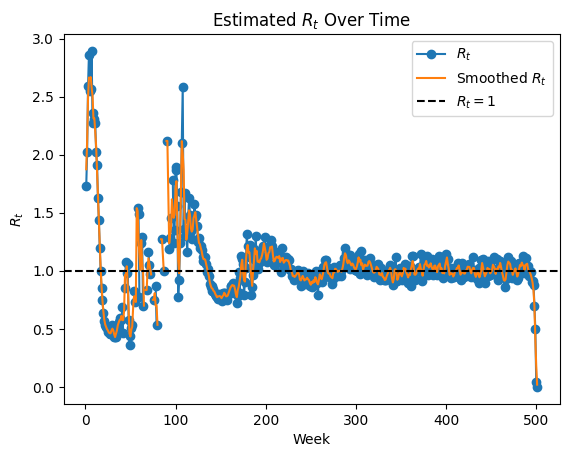

In [20]:
# Plot estimated R_t over time
plt.plot(rt_df['Week'], rt_df[r'R_t'], marker='o', label=r'$R_t$')
plt.plot(rt_df['Week'], rt_df[r'R_t_smooth'], label=r'Smoothed $R_t$')
plt.axhline(y=1.0, color='k', linestyle='--', label=r'$R_t=1$')
plt.xlabel('Week')
plt.ylabel(r'$R_t$')
plt.title(r'Estimated $R_t$ Over Time')
plt.legend()
plt.show()

### **Problem 2**
The goal of this problem is to get some simple practice with sensitivity and specificity, and get a little more familiar with confidence intervals too.

Suppose we've got a diagnostic with sensitivity $0.90$ and specificity $0.98$. 

a. Maria Lara conducts a prevalence study with the above diagnostic. She samples 100 people and gets 39 positives. What is your estimate of the prevalence after correcting for the sensitivity and specificity? 

In [23]:
se = 0.90
sp = 0.98

TP = 39/100 # first prevalence study
# TP = 18/50 # second prevalence study

prevalence = (TP - 1 + sp) / (se - 1 + sp)
print("Prevalence estimate =", prevalence)

Prevalence estimate = 0.42045454545454547


The probability that you test positive is $\theta se + (1-\theta)(1-sp)$ where $\theta$ is prevalence. Let's solve for prevalence.

\begin{align*}
\text{Pr(test positive)} &= \theta se + (1-\theta)(1-sp) \\
\text{Pr(test positive)} &= \theta se + 1 - sp - \theta + \theta sp \\
\text{Pr(test positive)} - 1 + sp &= \theta se - \theta + \theta sp \\
\text{Pr(test positive)} - 1 + sp &= \theta (se - 1 + sp) \\
\theta &= \frac{\text{Pr(test positive)} - 1 + sp}{se - 1 + sp}
\end{align*}

Now let's plug in our known values to find prevalence $\theta$.

\begin{align*}
\theta &= \frac{\text{Pr(test positive)} - 1 + sp}{se - 1 + sp} \\
\theta &= \frac{0.39 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta &= \frac{0.37}{0.88} \\
\theta &\approx 0.4205
\end{align*}

b. Write down a 95\% confidence interval for your corrected estimate. 

Again, we want to use a 95\% confidence interval for proportions. We know the sample proportion for a positive test $\hat{p}$ is $\frac{39}{100}$, $n=100$, and $z_{\alpha/2} = 1.96$ assuming normal distribution.

Let's write the 95\% confidence interval.
\begin{align*}
    \hat{p} &\pm 1.96\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}\\
    0.39 &\pm 1.96\sqrt{\frac{0.39(1-0.39)}{100}}\\
    0.39 &\pm 1.96\sqrt{\frac{0.39(0.61)}{100}}\\
    0.39 &\pm 1.96\sqrt{0.002379}\\
\end{align*}

Calculating this we get the interval for $p$ is $[p_{lower}, p_{upper}]$: $$\big[0.39 - 1.96(0.0488), 0.39+1.96(0.0488)\big]$$
    $$\big[0.2944, 0.4856\big]$$

Let's use this result to obtain a 95\% confidence interval for my $\theta$ estimate.

\begin{align*}
\theta_{lower} &\approx \frac{p_{lower} - 1 + sp}{se - 1 + sp} \\
\theta_{lower} &\approx \frac{0.2944 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta_{lower} &\approx \frac{0.2744}{0.88}\\
\theta_{lower} &\approx 0.3118
\end{align*}

\begin{align*}
\theta_{upper} &\approx \frac{p_{upper} - 1 + sp}{se - 1 + sp} \\
\theta_{upper} &\approx \frac{0.4856 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta_{upper} &\approx \frac{0.4656}{0.88}\\
\theta_{upper} &\approx 0.529
\end{align*}
The 95\% confidence found for my $\theta$ estimate is: $\left[0.3118, 0.529\right]$.

c. Trying to be helpful, Burt Q. Losis conducts a second prevalence study in the same population and finds 18 positives out of 50 samples. Again estimate the prevalence and a 95\% confidence interval.

Let's plug in our known values to find prevalence $\theta$ for the second prevalence study.

\begin{align*}
\theta &= \frac{\text{Pr(test positive)} - 1 + sp}{se - 1 + sp} \\
\theta &= \frac{0.36 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta &\approx \frac{0.34}{0.88} \\
\theta &\approx 0.3864
\end{align*}

Again, we want to use a 95\% confidence interval for proportions. We know the sample proportion for a positive test $\hat{p}$ is $\frac{18}{50}$, $n=50$, and $z_{\alpha/2} = 1.96$ assuming normal distribution.

Let's write the 95\% confidence interval.
\begin{align*}
    \hat{p} &\pm 1.96\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}\\
    0.36 &\pm 1.96\sqrt{\frac{0.36(1-0.36)}{50}}\\
    0.36 &\pm 1.96\sqrt{\frac{0.36(0.64)}{50}}\\
    0.36 &\pm 1.96\sqrt{0.004608}\\
\end{align*}

Calculating this we get the interval for $p$ is $[p_{lower}, p_{upper}]$: $$\big[0.36 - 1.96(0.06788), 0.36+1.96(0.06788)\big]$$
    $$\big[0.2269, 0.4930\big]$$

Let's use this result to obtain a 95\% confidence interval for my $\theta$ estimate.

\begin{align*}
\theta_{lower} &\approx \frac{p_{lower} - 1 + sp}{se - 1 + sp} \\
\theta_{lower} &\approx \frac{0.2269 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta_{lower} &\approx \frac{0.2069}{0.88}\\
\theta_{lower} &\approx 0.235
\end{align*}

\begin{align*}
\theta_{upper} &\approx \frac{p_{upper} - 1 + sp}{se - 1 + sp} \\
\theta_{upper} &\approx \frac{0.4930 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta_{upper} &\approx \frac{0.473}{0.88}\\
\theta_{upper} &\approx 0.5375
\end{align*}
The 95\% confidence found for my $\theta$ estimate is: $\left[0.235, 0.5375\right]$.

d. Pool Burt's and Maria's data to get a third estimate of prevalence, and update your 95\% confidence interval. How are your three estimates related? And, how are the widths of the three confidence intervals related?

For the pooled estimate of prevalence, we combine the total number of positives from both prevalence studies (39+18) and total number of samples together (100+50):

$$\text{proportion of TP} = \frac{39+18}{100+50} = \frac{57}{150} = 0.38$$

Now we can get the pooled estimate of prevelance:
\begin{align*}
\theta &= \frac{\text{Pr(test positive)} - 1 + sp}{se - 1 + sp} \\
\theta &= \frac{0.38 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta &= \frac{0.36}{0.88} \\
\theta &\approx 0.4091
\end{align*}

Let's update the 95\% confidence interval now.
\begin{align*}
    \hat{p} &\pm 1.96\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}\\
    0.38 &\pm 1.96\sqrt{\frac{0.38(1-0.38)}{150}}\\
    0.38 &\pm 1.96\sqrt{\frac{0.38(0.62)}{150}}\\
    0.38 &\pm 1.96\sqrt{0.00157}\\
\end{align*}

Calculating this we get the interval for $p$ is $[p_{lower}, p_{upper}]$:
$$\big[0.38 - 1.96(0.03963), 0.38+1.96(0.03963)\big]$$
$$\big[0.3023, 0.4577\big]$$

Let's use this result to obtain a 95\% confidence interval for my $\theta$ estimate.

\begin{align*}
\theta_{lower} &\approx \frac{p_{lower} - 1 + sp}{se - 1 + sp} \\
\theta_{lower} &\approx \frac{0.3023 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta_{lower} &\approx \frac{0.2823}{0.88}\\
\theta_{lower} &\approx 0.3208
\end{align*}

\begin{align*}
\theta_{upper} &\approx \frac{p_{upper} - 1 + sp}{se - 1 + sp} \\
\theta_{upper} &\approx \frac{0.4577 - 1 + 0.98}{0.90 - 1 + 0.98} \\
\theta_{upper} &\approx \frac{0.4377}{0.88}\\
\theta_{upper} &\approx 0.4974
\end{align*}
The 95\% confidence found for my $\theta$ estimate is: $\left[0.3208, 0.4974\right]$.

The estimates we have obtained are:

* Study 1 (Maria Lara):  $\theta \approx 0.4205$ ; 95\% confidence interval: $[0.3118, 0.529]$
* Study 2 (Pool Burt): $\theta \approx 0.3864$; 95\% confidence interval: $\left[0.235, 0.5375\right]$
* Pooled (Both): $\theta \approx 0.4091$; 95\% confidence interval: $\left[0.3208, 0.4974\right]$


We notice that the pooled estimate of 0.4091 lies between the estimates of the first and second study, but is closer to the first study since the sample size was larger. Because we pooled, the width of the pooled confidence interval is smallest, whereas the width for the second study is largest. This makes sense because the second study had less samples, so there is more uncertainty about the prevalence estimate. Similarly, the pooled estimate had the combined number of samples, and thus the pooled prevalence estimate has the least amount of uncertainty. From this, we can see that pooling increases effective sample size and thus reduces uncertainty.

e. (Grad / EC) You test yourself. Positive! What is your best guess of the probability that you are *actually* positive?

For this problem, we need to calculate positive predictive value (PPV). Below is the formula to calculate this.
\begin{align*}
    \text{Pr(truly positive | tested positive)} &= \frac{\text{Pr(tested positive | truly positive)} \times \text{truly positive}}{\text{Pr(tested positive)}}\\
    PPV &= \frac{se \theta}{se \theta + (1-sp)(1-\theta)}\\
    &= \frac{TP}{TP+FP}
\end{align*}
Using our pooled estimated $\theta=0.4091$ and the given sensitivity and specificity of the test, we can calculate PPV for myself.
\begin{align*}
    PPV &= \frac{se \theta}{se \theta + (1-sp)(1-\theta)}\\
    &= \frac{0.90 \cdot 0.4091}{0.90 \cdot 0.4091+ (1-0.98)(1-0.4091)}\\
    &= \frac{0.36819}{0.380008}\\
    PPV &\approx 0.9689
\end{align*}

This means there is 96.89\% chance that I am actually positive, which is pretty high!

### **Problem 3**
The goal of this problem is to learn about how sensitivity and specificity arise from calibration data, i.e. from positive and negative controls. For this problem, you will need to read in three .csv files to access the data they contain:

* **HW4\_Q3\_neg.csv**: The assay values associated with a set of negative controls. 
* **HW4\_Q3\_pos.csv**: The assay values associated with a set of positive controls. 
* **HW4\_Q3\_data.csv**: The assay values associated with your prevalence study in the population.

a. Read in the data and produce a tall, skinny plot with three columns of data: the negative controls (red), the positive controls (black), and the data from the field (blue). Use jitter and transparency ("alpha") to allow us to see the distributions of the data. 

In [ ]:
# Load all_weeks.csv data
import pandas as pd
import numpy as np

neg_df = pd.read_csv('hw4_data/HW4_Q3_neg.csv', header=None)
pos_df = pd.read_csv('hw4_data/HW4_Q3_pos.csv', header=None)
data_df = pd.read_csv('hw4_data/HW4_Q3_data.csv', header=None)
print(f"Shape of neg_df: {neg_df.shape}") # (200, 1)
print(f"Shape of neg_df: {pos_df.shape}") # (300, 1)
print(f"Shape of neg_df: {data_df.shape}") # (300, 1)

b. Consider a cutoff $c$ such that any assay values above $c$ are to be called positive and any assay values below $c$ are to be called negative. Then write four functions: $se(c)$, $sp(c)$, and $\hat{\phi}(c)$ and $\hat{\theta}(c)$. They should correspond to the sensitivity, the specificity, the raw prevalence in the field data, and the corrected prevalence in the field data. What value of $c$ corresponds to the "Youden" choice?

c. (Grad / EC) By sweeping over various choices of $c$, plot a receiver operator curve, and place a point at the Youden choice. Create a second plot showing how $\hat{\theta}(c)$ varies, and again, place a point at the Youden choice. 

d. Write 3-4 sentences reflecting on how the conclusions of a study might be affected by how one decides to choose the cutoff at which positives and negatives are called. 